## 0 Read in data and NLTK Basics

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

plt.style.use('ggplot')

import nltk

In [8]:
# dataset = load_dataset("tweet_eval", "sentiment")
# dataset = load_dataset("amazon_us_reviews","Camera_v1_00")
dataset = load_dataset("app_reviews")
df = pd.DataFrame(dataset['train'])


Found cached dataset app_reviews (C:/Users/Splute/.cache/huggingface/datasets/app_reviews/default/0.0.0/20335b51b604b9bc04b7be253cd8445caa9ba93f15f39a4b0492b9e9102853de)


  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
# 按照"star"列进行分组
grouped = df.groupby('star')

# 初始化一个空的DataFrame，用于存放随机选择的样本
random_sample_df = pd.DataFrame()

# 遍历每个分组，从每个分组中随机选择100个样本，并添加到random_sample_df中
for group_name, group_data in grouped:
    if len(group_data) >= 100:
        random_sample = group_data.sample(100, random_state=66)  # 使用随机种子(random_state)确保结果可复现
    else:
        random_sample = group_data  # 如果某个类别样本数量小于100，则全部选择
    random_sample_df = random_sample_df.append(random_sample)

# 打印结果
print(random_sample_df['star'].value_counts())

5    100
4    100
3    100
2    100
1    100
Name: star, dtype: int64


In [13]:
df = random_sample_df
# 添加一个新的整数索引，并将其保存为'id'列
df['id'] = df.reset_index(drop=True).index
# 将'id'列移动到最左边
id_column = df['id']  # 获取'id'列
df.drop(columns=['id'], inplace=True)  # 删除'id'列
df.insert(0, 'id', id_column)  # 将'id'列插入到第一列

df

,id,package_name,review,date,star
246269,0,com.google.android.gms,Unnecessary update,March 21 2017,1
274412,1,com.google.android.gms,Why do. You force to use.this is 2 in1. With W...,April 28 2017,1
226081,2,com.google.android.gms,Lagg!! It crashes my YouTube I had to restart ...,February 24 2017,1
95157,3,com.dozuki.ifixit,Crap application,February 19 2016,1
237696,4,com.google.android.gms,Rubbish,March 12 2017,1
...,...,...,...,...,...
349,495,com.pilot51.voicenotify,DJCoulton Works great. Very nice indeed,May 26 2014,5
123031,496,com.frostwire.android,Lime line you have to has Frost wire love them...,December 06 2016,5
2289,497,org.openintents.filemanager,Awesome file manager This is a great file mana...,January 21 2014,5
214585,498,com.google.android.gms,Nice but irritating. Its a good app. But who t...,February 04 2017,5


In [14]:
# ax = df['star_rating'].value_counts().sort_index() \
#     .plot(kind='bar',
#         title='Count of Reviews by Stars',
#         figsize=(6,3))

# ax.set_xlabel('Review Stars')
# plt.show()

## 1 VADER
each word is scored and combined to a total score

In [15]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm ## to add progress bars to loops and iterations

sia = SentimentIntensityAnalyzer()

In [16]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.373, 'pos': 0.627, 'compound': 0.7213}

In [18]:
# run on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['review']
    myid = row['id']
    res[myid] = sia.polarity_scores(text)


  0%|          | 0/500 [00:00<?, ?it/s]

In [19]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'id'})
vaders = vaders.merge(df, how='left')

In [20]:
vaders.head()

,id,neg,neu,pos,compound,package_name,review,date,star
0,0,0.000,1.000,0.0,0.0000,com.google.android.gms,Unnecessary update,March 21 2017,1
1,1,0.000,1.000,0.0,0.0000,com.google.android.gms,Why do. You force to use.this is 2 in1. With W...,April 28 2017,1
2,2,0.000,1.000,0.0,0.0000,com.google.android.gms,Lagg!! It crashes my YouTube I had to restart ...,February 24 2017,1
3,3,0.722,0.278,0.0,-0.3818,com.dozuki.ifixit,Crap application,February 19 2016,1
4,4,0.000,1.000,0.0,0.0000,com.google.android.gms,Rubbish,March 12 2017,1


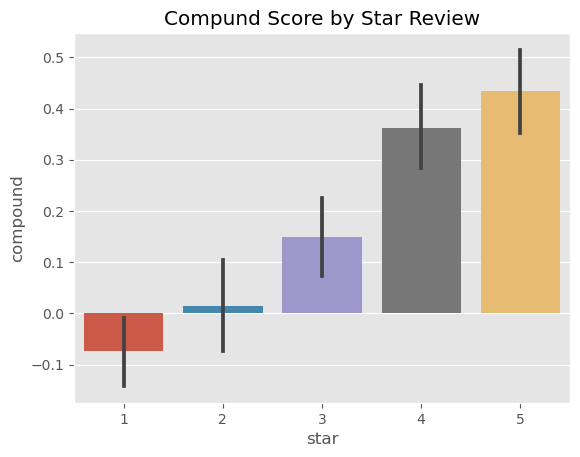

In [22]:
## plot vader results
ax = sns.barplot(data=vaders, x='star', y = 'compound')
ax.set_title('Compund Score by Star Review')
plt.show()

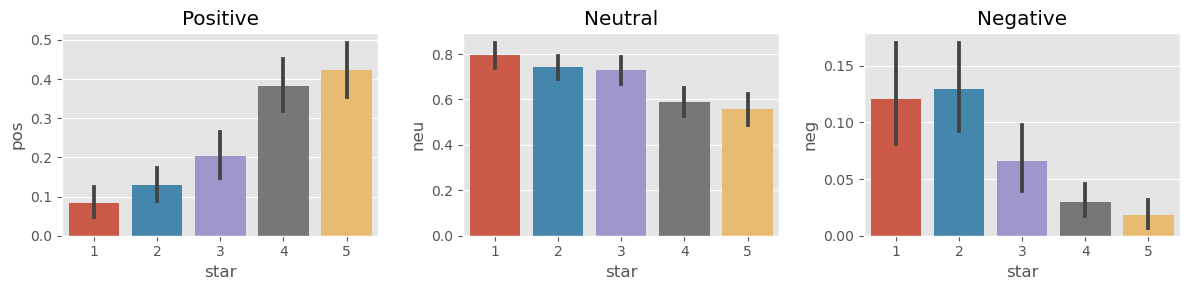

In [24]:
fig, axs = plt.subplots(1, 3, figsize = (12,3))
sns.barplot(data=vaders, x='star', y = 'pos', ax=axs[0])
sns.barplot(data=vaders, x='star', y = 'neu', ax=axs[1])
sns.barplot(data=vaders, x='star', y = 'neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

## Roberta pretrained Model

In [25]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [26]:
MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [27]:
example = 'How would you feel, if I... if I gave you your copy in person?'

In [28]:
#for VADER
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [29]:
# for roBerta
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}
print(scores_dict)

{'roberta_neg': 0.14380644, 'roberta_neu': 0.6762827, 'roberta_pos': 0.17991084}


In [30]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }

    return scores_dict

In [31]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['review']
        myid = row['id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}

        res[myid] = both
    except RuntimeError:
        print(f"Broke for id {myid}")


  0%|          | 0/500 [00:00<?, ?it/s]

In [32]:
result_df = pd.DataFrame(res).T
result_df = result_df.reset_index().rename(columns={'index':'id'})
result_df = result_df.merge(df, how='left')

In [33]:
result_df.head()

,id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,package_name,review,date,star
0,0,0.000,1.000,0.0,0.0000,0.895684,0.081939,0.022377,com.google.android.gms,Unnecessary update,March 21 2017,1
1,1,0.000,1.000,0.0,0.0000,0.154255,0.778604,0.067141,com.google.android.gms,Why do. You force to use.this is 2 in1. With W...,April 28 2017,1
2,2,0.000,1.000,0.0,0.0000,0.895931,0.078863,0.025206,com.google.android.gms,Lagg!! It crashes my YouTube I had to restart ...,February 24 2017,1
3,3,0.722,0.278,0.0,-0.3818,0.858376,0.093831,0.047793,com.dozuki.ifixit,Crap application,February 19 2016,1
4,4,0.000,1.000,0.0,0.0000,0.880506,0.076622,0.042872,com.google.android.gms,Rubbish,March 12 2017,1


## 3 Compare Scores between Models

In [34]:
result_df.columns

Index(['id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'package_name', 'review',
       'date', 'star'],
      dtype='object')

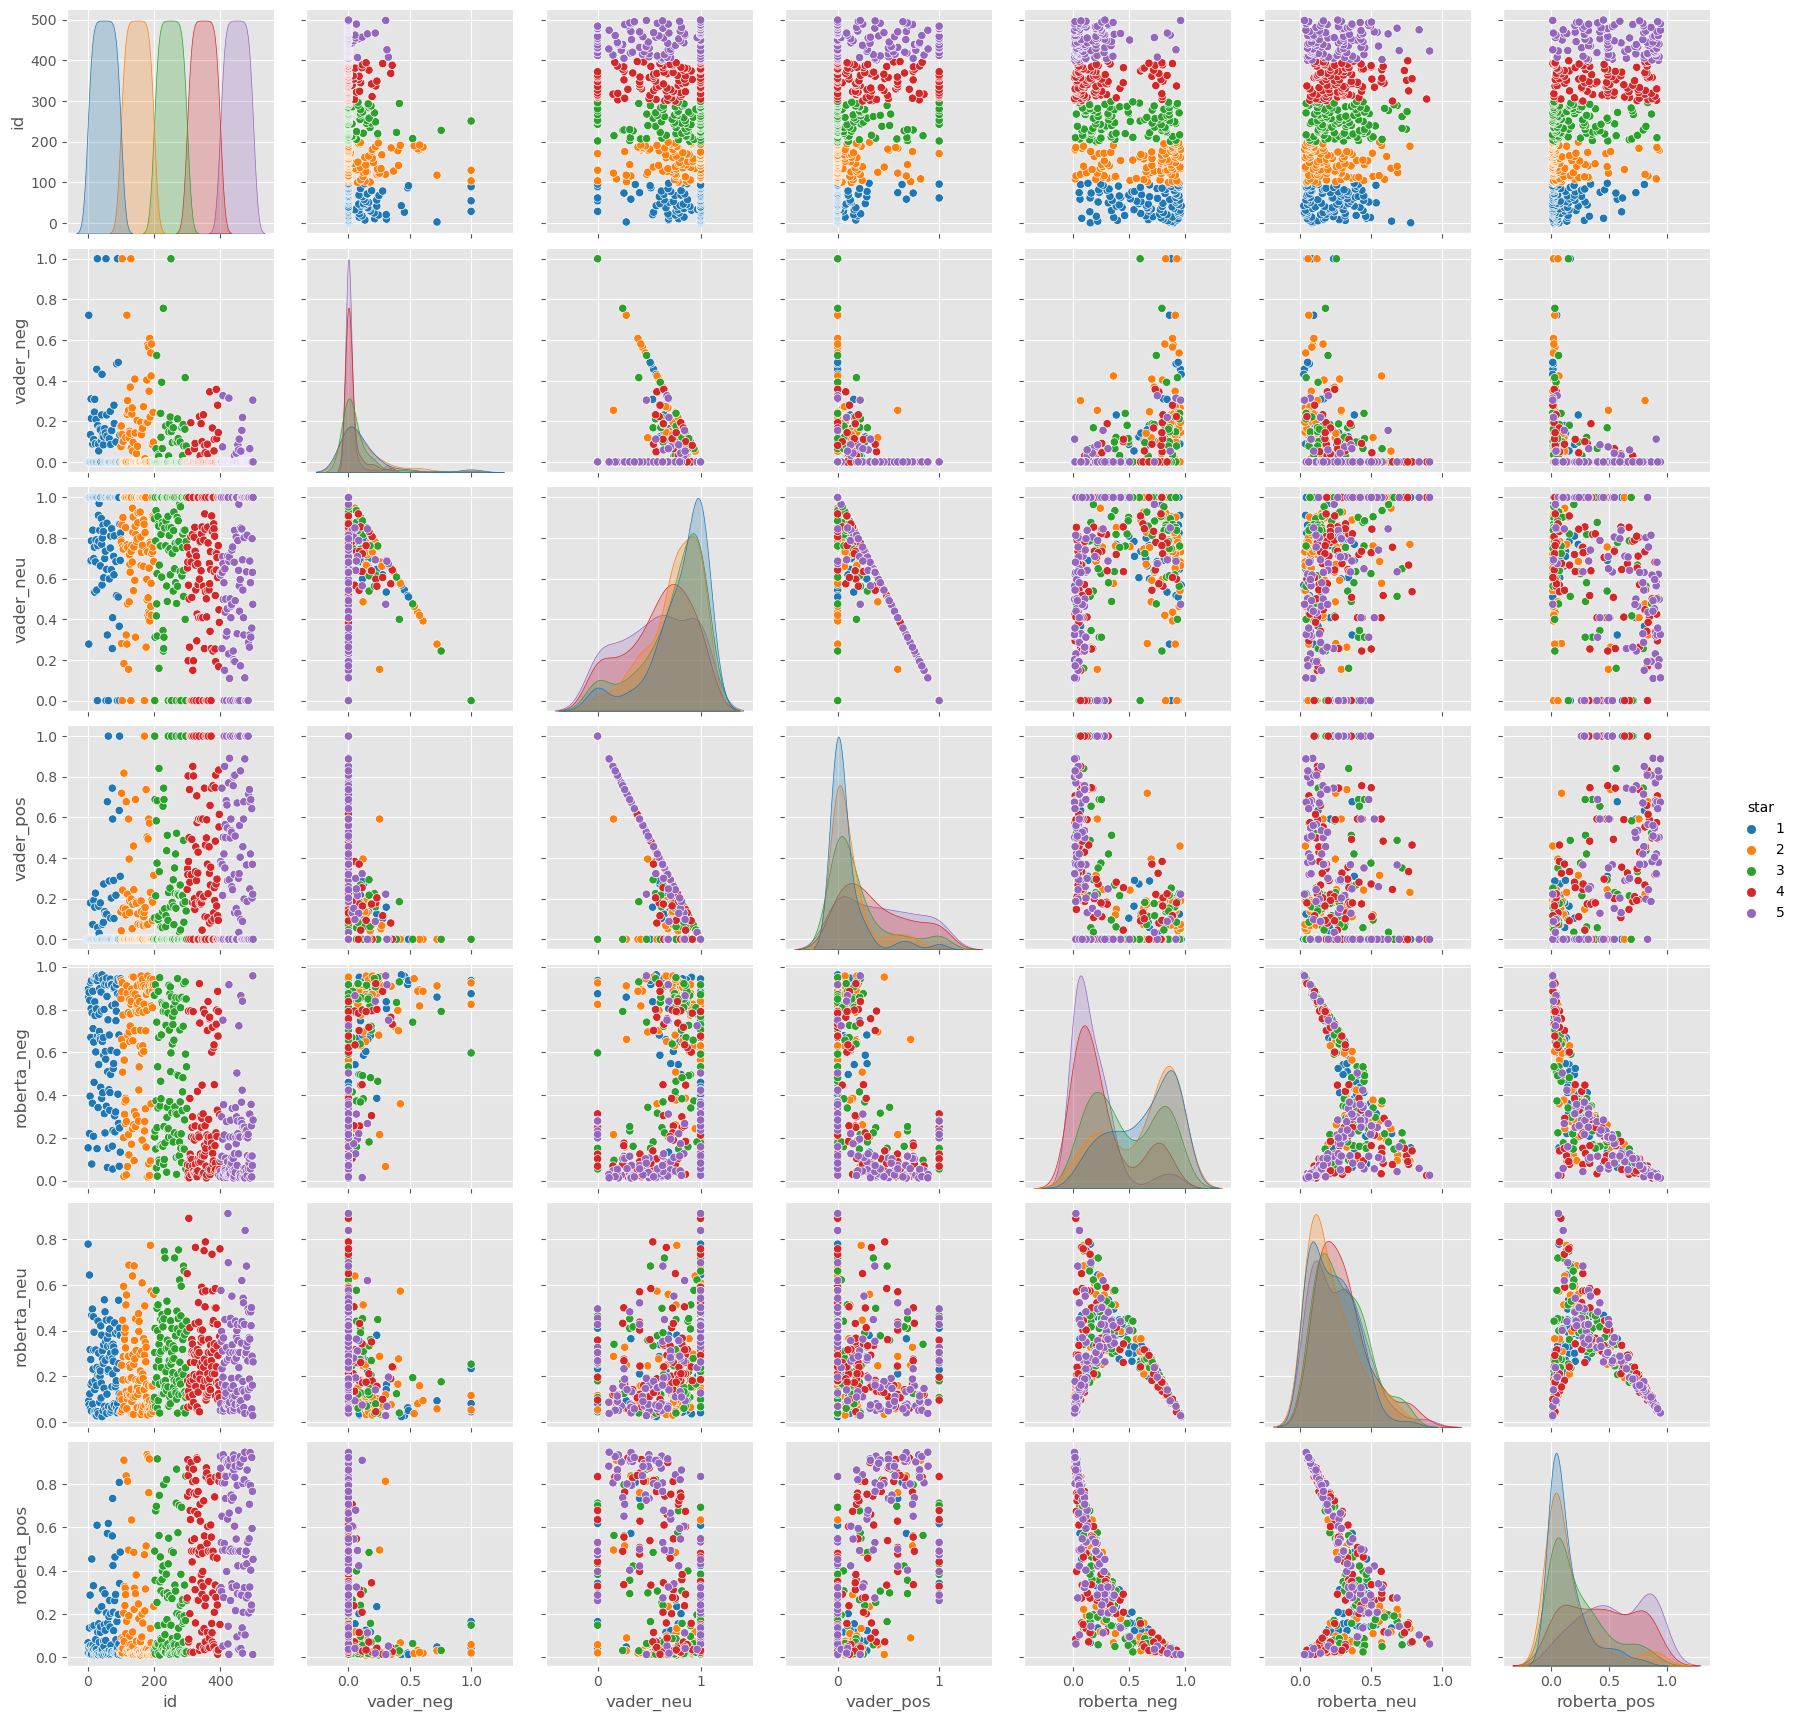

In [36]:
sns.pairplot(data = result_df, 
            vars=['id', 'vader_neg', 'vader_neu', 'vader_pos',
                    'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue = 'star',
            palette = 'tab10')

plt.show()

## Extra: the pipline

In [57]:
from transformers import pipeline

sent_pipline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [58]:
eg = 'how would you feel if you will never see me?'
sent_pipline(eg)

[{'label': 'NEGATIVE', 'score': 0.9986938834190369}]

## The End